In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from obspy import Trace, Stream, read
import scipy
from scipy.integrate import cumtrapz
from scipy.fftpack import fft, ifft, fft2, ifft2, fftshift, ifftshift, fftfreq
from scipy import signal
from scipy import ndimage
import math
from math import ceil

%load_ext autoreload
%autoreload 2



In [1]:
def segy2stream(path, network, channel_spacing=1, units='Strain rate'):
    """
    Reads in SEGY file and outputs and obspy stream with correct header information.
    
    Arguments:
    Required:
    st - obspy stream
    path - path of segy file 
    id - unique file name

    Returns:
    obspy stream
    7-Nov-2021, read trace header
    """
    
    st=read(path, format='SEGY', unpack_trace_headers=True, headonly=False)

    for i in range(len(st)):
        
#         st[i].stats.distance=(tr.stats.segy.trace_header.x_coordinate_of_ensemble_position_of_this_trace)/1000
        st[i].stats.distance=(i*channel_spacing)
        st[i].stats.network=network
        st[i].stats.channel='Z'
        st[i].stats.units = units
    
    return st

def stream2array(st):
    """
    Populates a 2D np.array that is the traces as rows by the samples as cols.
    
    Arguments:
    Required:
    st - obspy stream

    Returns:
    nparray - numpy array
    """
    
    nparray=np.empty((len(st),len(st[0].data)),dtype=float) # initialize
    for index,trace in enumerate(st):
        check=len(nparray[index,:])-len(trace.data)
        if check != 0:
            trace.data=np.resize(trace.data, len(nparray[index,:]))
        
        nparray[index,:]=trace.data

    return nparray

def segy2stream(path, network, channel_spacing=1.02, units='Strain rate'):
    """
    Reads in SEGY file and outputs and obspy stream with correct header information.
    
    Arguments:
    Required:
    st - obspy stream
    path - path of segy file 
    id - unique file name

    Returns:
    obspy stream
    7-Nov-2021, read trace header
    """
    
    st=read(path, format='SEGY', unpack_trace_headers=True, headonly=False)

    for i in range(len(st)):
        
#         st[i].stats.distance=(tr.stats.segy.trace_header.x_coordinate_of_ensemble_position_of_this_trace)/1000
        st[i].stats.distance=(i*channel_spacing)
        st[i].stats.network=network
        st[i].stats.channel='Z'
        st[i].stats.units = units
    
    return st

def image(st,style=1,skip=10,clim=[0],tmin=0,tmax=None,
        physicalFiberLocations=False, picks=None,
        distance_unit='km', xlabel='Offset',fig=None):
    """
    Simple image plot of DAS Stream, adapted from IRIS DAS workshop function.
    #skip=10 is default to skip every 10 ch for speed
    #style=1 is a raw plot, or 2 is a trace normalized plot
    #clim=[min,max] will clip the colormap to [min,max], deactivated by default
    
    Arguments:
    Required:
    st - The stream containing the DAS data to plot.
    Optional:
    style - Type of plot. Default is raw plot (style=1). style=2 is a trace normalized plot. 
    skip - The decimation in the spatioal domain. Default is 10. (int)
    clim - If specified, it is a list containing the lower and upper 
            limits of the colormap. Default is [], which specifies 
            that python defaults should be used. (list of 2 ints)
    tmin - Plot start time in seconds.
    tmax - Plot end time in seconds.
    physicalFiberLocations - Defines distance from header information.
    picks - DASpy event object. If specified, will plot phase picks 
            on the figure. Default is None, which specifies it is 
            unused. (DASpy detect.detect.event object)

    Returns:
    fig - A python figure object.
    """
    
    
    if fig==None:
        fig = plt.figure(figsize=(8,7))
#     fig = plt.figure()
    if style==1:
        img = stream2array(st[::skip]) # raw amplitudes
        clabel = st[0].stats.units
    if style==2:
        img = stream2array(st[::skip].copy().normalize()) # trace normalize
        clabel = st[0].stats.units+' (trace normalized)'

    t_ = st[0].stats.endtime-st[0].stats.starttime
    if physicalFiberLocations==True:
        extent = [st[0].stats.distance/1e3,st[-1].stats.distance/1e3,0,t_]
        if distance_unit=='m':
            extent = [st[0].stats.distance,st[-1].stats.distance,0,t_]
        xlabel = '{} [{}]'.format(xlabel,distance_unit) # relative to wellhead
    else:
        dx_ = st[1].stats.distance - st[0].stats.distance
        extent = [0,len(st)*dx_/1e3,0,t_]
        if distance_unit=='m':
            extent = [0,len(st)*dx_,0,t_]
        xlabel = 'Linear Fiber Length [{}]'.format(distance_unit)
    if len(clim)>1:
        plt.imshow(img.T,aspect='auto',interpolation='gaussian',alpha=0.7,
                   origin='lower',extent=extent,vmin=clim[0],vmax=clim[1],cmap="seismic");
    else:
        plt.imshow(img.T,aspect='auto',interpolation='gaussian',alpha=0.7,
                   origin='lower',extent=extent,cmap="seismic");
        
        
    try: 
        if distance_unit=='km':
            plt.scatter(picks.x/1000,picks.t,marker='_',c='k')
        if distance_unit=='m':
            plt.scatter(picks.x,picks.t,marker='_',c='k')
    except:
        pass
        
 


    h=plt.colorbar(pad=0.01);
    h.set_label(clabel,fontsize=12)
#     plt.ylim(np.max(extent),0)
    plt.ylabel('Time [s]',fontsize=14);
    plt.xlabel(xlabel,fontsize=14);
    
    if tmax:
        plt.ylim(tmax,tmin)
    else:
        plt.ylim(np.max(extent),tmin)

    # plt.gca().set_title(str(st[0].stats.starttime.datetime)+' - '+str(st[0].stats.endtime.datetime.strftime('%H:%M:%S'))+' (UTC)');

    plt.tight_layout();

    return fig

def median_remove(st):
    '''
    Remove median of all channels for each time step. Compared with removing mean, removing median does not generate zeros at zero wavenumber, which keeps f-k plot smooth.
    
    Arguments:
    st - Stream of DAS data to apply notch filter to (obspy stream)
    Returns:
    st_shp - median removed Stream.
    '''
    
    image=stream2array(st)
    
    image2=image - np.median(image, axis=0)
    
    st_shp=st.copy()
    for channel in range(len(image2)):
        st_shp[channel].data=image2[channel]
        
    return st_shp

def taper_cos_1D(nt_tot, ntap, nzeros):
        # if nt_tot is even, nzeros must be even and at least 2
        # if nt_tot is odd, nzeros must be odd and at least 1 
        n_half = ceil(nt_tot/2)
        tap_tmp = np.ones(n_half-(ceil(nzeros/2)-1))
        for i in range(0, ntap):
            val = 0.5*(1-np.cos((np.pi*i)/(ntap))) 
            tap_tmp[i] = val        
        tap_tmp = np.concatenate((np.zeros(ceil(nzeros/2)-1), tap_tmp))        
        
        if nt_tot%2 != 0:
            tap1d_out = np.concatenate((tap_tmp[:0:-1], tap_tmp))
        else:
            tap1d_out = np.concatenate((tap_tmp[::-1], tap_tmp))
        
        return tap1d_out

def fk_filter(st, wavenumber_limits=(-0.5, 0.5), freq_limits=(-1000, 1000), taper=0,resample=False,eta=1e-2,plot=True):
    '''
    FK filter for a 2D DAS numpy array. Returns a filtered image.
    Arguments:
    st - Stream of DAS data to apply notch filter to (obspy stream)
    wavenumber - maximum value for the filter  
    max_freq - maximum value for the filter  
    Returns:
    st_fk - FK filtered time series.
    17/March/2022: add tapering function before fk
    '''
    data=stream2array(st).T
    ns_t, ns_x = data.shape
    print(ns_t, ns_x)
    
    if taper>0:
        data = data * signal.tukey(ns_x, alpha=taper)
        data = (data.T * signal.tukey(ns_t, alpha=taper)).T
    
    fs=st[0].stats.sampling_rate
    ch_space=abs(st[1].stats.distance-st[0].stats.distance)

    # Detrend by removing the mean 
    data=data-np.mean(data)
    
    # Apply a 2D fft transform
    fftdata=np.fft.fftshift(np.fft.fft2(data.T))
    
    freqs=np.fft.fftfreq(ns_t,d=(1./fs))
    wavenums=2*np.pi*np.fft.fftfreq(ns_x,d=ch_space)
    
    freqs=np.fft.fftshift(freqs) 
    wavenums=np.fft.fftshift(wavenums)

    freqsgrid=np.broadcast_to(freqs,fftdata.shape)   
    print(freqsgrid.shape)

    wavenumsgrid=np.broadcast_to(wavenums,fftdata.T.shape).T
    print(wavenumsgrid.shape)
    
    mask=np.logical_and(np.logical_and(wavenumsgrid>=wavenumber_limits[0], wavenumsgrid<=wavenumber_limits[1]),
                            np.logical_and(freqsgrid>=freq_limits[0], freqsgrid<=freq_limits[1]))
    x=mask*1.

    blurred_mask = ndimage.gaussian_filter(x, sigma=3)
    
    if resample==True:
        # Convert from strain to velocity. Assumes DAS units are strain in m/m, ie *1e-9 and integrated.
        data_resample=np.zeros(fftdata.shape,dtype=np.complex_)
        tap1d = taper_cos_1D(len(wavenums), 10, 1)  

        for i in range(len(wavenums)):
            # data_resample[i]=(11.6*10**-9)*fftdata[i]*((-1*wavenums[i]+eta)/(2*np.pi*(freqs)+eta))
            # data_resample[i]=fftdata[i]*((-1*wavenums[i]+eta)/(2*np.pi*(freqs)+eta))
            data_resample[i]=fftdata[i]*((-2*np.pi*(freqs)+eta)/(wavenums[i]+eta))

        tap1d_2 = taper_cos_1D(len(wavenums), 10, 1)   
        tap2d_2 = np.repeat([tap1d_2],len(freqs),axis=0).T 
        
        data_resample = data_resample * tap2d_2
           
        ftimagep_tmp = data_resample * blurred_mask    
        ftimagep = np.fft.ifftshift(ftimagep_tmp)
        
        for tr in st:
            tr.stats.units="Velocity"
            
    else:
        # Apply the mask to the data and rettransform back to the time-domain
        ftimagep_tmp = fftdata * blurred_mask
    
        ftimagep = np.fft.ifftshift(ftimagep_tmp)
    
    if plot==True:
        # Plots the filter, with area remove greyed out
        max_val=np.max(abs(ftimagep_tmp)) 
        fig = plt.figure(figsize=[6,6])
        img1 = plt.imshow(abs(ftimagep_tmp), interpolation='bilinear',extent=[-fs/2,fs/2,-1/(2*ch_space),1/(2*ch_space)],aspect='auto')
        img1.set_clim(-1*max_val,max_val)
        img1 = plt.imshow(abs(blurred_mask-1),cmap='Greys',extent=[-fs/2,fs/2,-1/(2*ch_space),1/(2*ch_space)],alpha=0.2,aspect='auto')

        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Wavenumber (1/m)')
        xrange=300
        yrange=0.1
        plt.xlim(-1*xrange,xrange)
        plt.ylim(-1*yrange,yrange)
        plt.show()
    
    # Finally, take the inverse transform 
    imagep = np.fft.ifft2(ftimagep)
    imagep = imagep.real
    
    # Convert back to a stream        
    st_fk=st.copy()
    for channel in range(len(imagep)):
        st_fk[channel].data=imagep[channel]
        
        
    return st_fk

# Read in example event from 27/04/2019 at 20:20hrs UTC

In [2]:
# Define directories and file names
datadir = "data/"
event_ps1_way = {"geo": ("20190427202045.868.segy", 24270), "das": ("DAS_FORGE_201904272020575.segy",9150)}

## Geophone Data

In [4]:
fpath_ps1_geo = datadir + "/" + event_ps1_way["geo"][0]
st_ps1_geo = read(fpath_ps1_geo, format='SEGY', unpack_trace_headers=True)
print(st_ps1_geo)

# Apply conversion factor, filter and integrate to velocity or displacement
convert_factor = 2.333*pow(10,-7)

for tr in st_ps1_geo:
    tr.data=tr.data*convert_factor
    median = np.median(tr.data,axis=0)
    tr.data=tr.data-median
    tr.filter(type='bandpass',freqmin=5,freqmax=250)
    
    # Velocity
    tr.integrate(method='cumtrapz')
    tr.stats.units="Velocity"
    # # Displacement
    # tr.integrate(method='cumtrapz')

36 Trace(s) in Stream:

Seq. No. in line:    0 | 2019-04-27T20:20:45.000000Z - 2019-04-27T20:21:00.999500Z | 2000.0 Hz, 32000 samples
...
(34 other traces)
...
Seq. No. in line:    0 | 2019-04-27T20:20:45.000000Z - 2019-04-27T20:21:00.999500Z | 2000.0 Hz, 32000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


Event depth 767.2


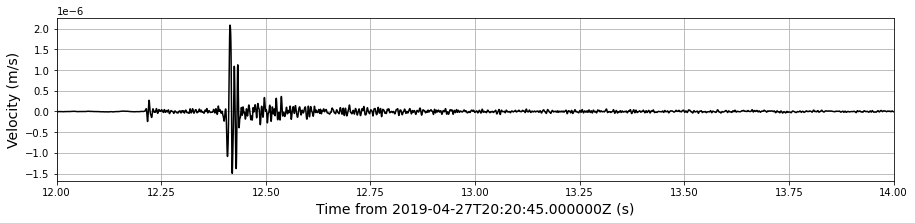

In [5]:
trace=13
print('Event depth %s' %(st_ps1_geo[trace].stats.segy['trace_header']['receiver_group_elevation']/100))
start=st_ps1_geo[trace].stats.starttime

plt.figure(figsize=[15,3])
plt.plot(st_ps1_geo[trace].times(),st_ps1_geo[trace].data,'k')

plt.xlim(12,14)
plt.xlabel('Time from %s (s)'%(start),fontsize=14)
# plt.ylabel('Displacement (m)',fontsize=14)
plt.ylabel('Velocity (m/s)',fontsize=14)

plt.grid()
plt.show()

In [6]:
print('Event depth %s' %(st_ps1_geo[0].stats.segy['trace_header']['receiver_group_elevation']/100))
print(st_ps1_geo[10].stats)

Event depth 645.28
         network: 
         station: 
        location: 
         channel: 
       starttime: 2019-04-27T20:20:45.000000Z
         endtime: 2019-04-27T20:21:00.999500Z
   sampling_rate: 2000.0
           delta: 0.0005
            npts: 32000
           calib: 1.0
         _format: SEGY
      processing: ["ObsPy 1.3.0: filter(options={'freqmin': 5, 'freqmax': 250}::type='bandpass')", "ObsPy 1.3.0: integrate(method='cumtrapz'::options={})"]
            segy: AttribDict({'trace_header': AttribDict({'endian': '>', 'unpacked_header': None, 'trace_sequence_number_within_line': 0, 'trace_sequence_number_within_segy_file': 0, 'original_field_record_number': 0, 'trace_number_within_the_original_field_record': 0, 'energy_source_point_number': 0, 'ensemble_number': 0, 'trace_number_within_the_ensemble': 0, 'trace_identification_code': 2, 'number_of_vertically_summed_traces_yielding_this_trace': 0, 'number_of_horizontally_stacked_traces_yielding_this_trace': 0, 'data_use': 0, 'd

## DAS Data

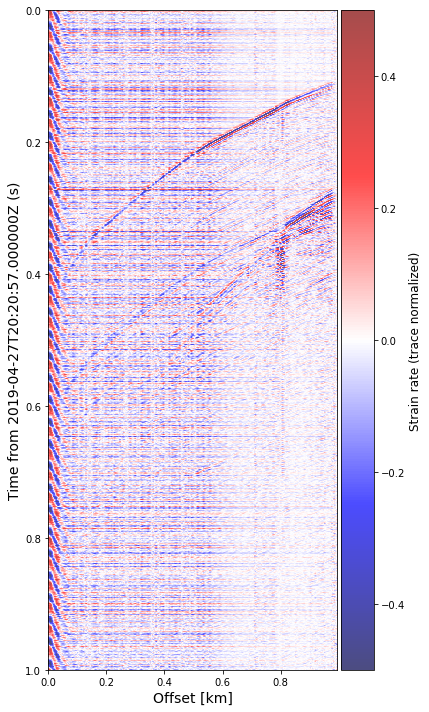

In [8]:
fpath_ps1_DAS = datadir + "/" + event_ps1_way["das"][0]

st_zoom=segy2stream(fpath_ps1_DAS,network='FORGE',channel_spacing=1.02)

das_start=st_zoom[0].stats.starttime

fig=plt.figure(figsize=[6,10])
fig=image(st_zoom,style=2,skip=1,tmax=1,clim=[-0.5,0.5], physicalFiberLocations=True,fig=fig)
plt.ylabel('Time from %s (s)'%(das_start),fontsize=14)
plt.show()

### Detrend and remove median of time axis

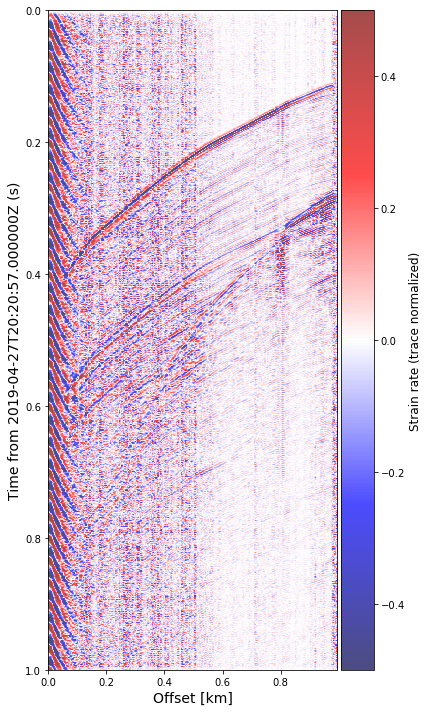

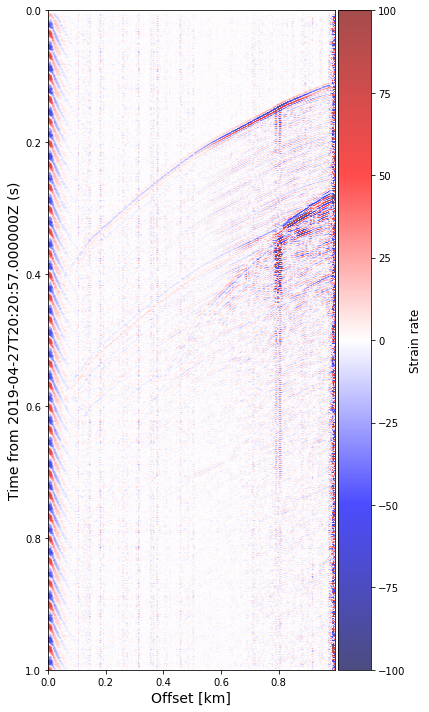

In [9]:
st_zoom.taper(max_percentage=0.01,type='cosine')
st_bp=st_zoom.copy()
st_bp=st_bp.filter(type='bandpass',freqmin=10,freqmax=250)

st_bp=median_remove(st_bp)

das_start=st_zoom[0].stats.starttime
for tr in st_bp:
    tr=tr.detrend(type="linear")
    tr=tr.detrend(type="demean") 

fig=plt.figure(figsize=[6,10])
fig=image(st_bp,style=2,skip=1,tmax=1,clim=[-0.5,0.5], physicalFiberLocations=True,fig=fig)
plt.ylabel('Time from %s (s)'%(das_start),fontsize=14)
plt.show()

fig=plt.figure(figsize=[6,10])
fig=image(st_bp,style=1,skip=1,tmax=1,clim=[-100,100], physicalFiberLocations=True,fig=fig)
plt.ylabel('Time from %s (s)'%(das_start),fontsize=14)
plt.show()


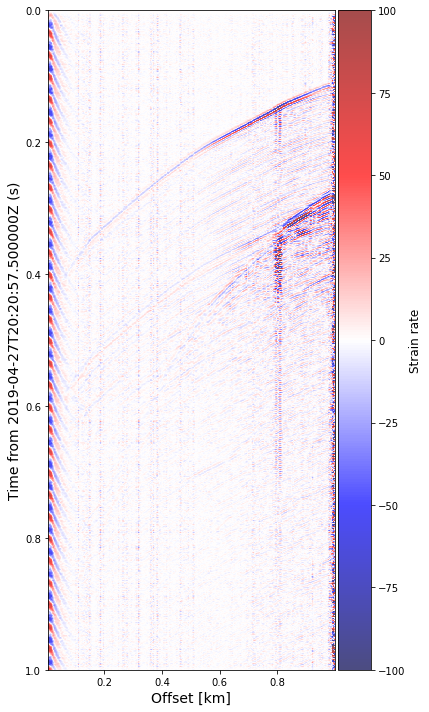

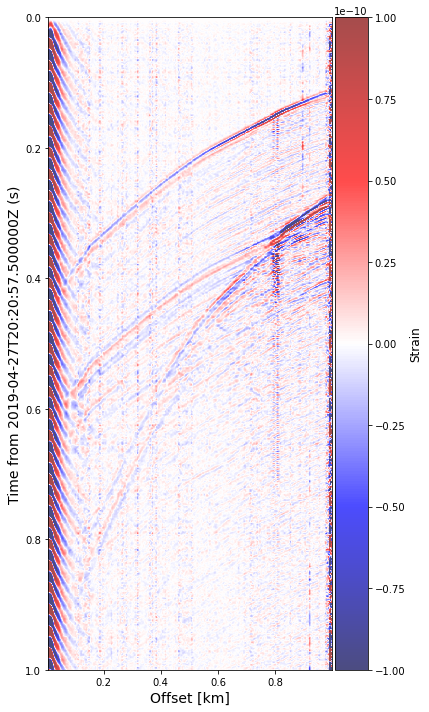

In [10]:
fig=plt.figure(figsize=[6,10])
fig=image(st_bp,style=1,skip=1,tmax=1,clim=[-100,100], physicalFiberLocations=True,fig=fig)
plt.ylabel('Time from %s (s)'%(das_start),fontsize=14)
plt.show()

st_strain=st_bp.copy()

for tr in st_strain:
    # Convert from nm/s/s to m/s 
    tr.data=tr.data*1e-9
    tr.integrate(method='cumtrapz')
    tr.stats.units="Strain"
    
st_strain=st_strain.filter(type='bandpass', freqmin=10,freqmax=400)

fig=plt.figure(figsize=[6,10])
fig=image(st_strain,style=1,skip=1,tmax=1,clim=[-1e-10,1e-10], physicalFiberLocations=True,fig=fig)
plt.ylabel('Time from %s (s)'%(das_start),fontsize=14)
plt.show()



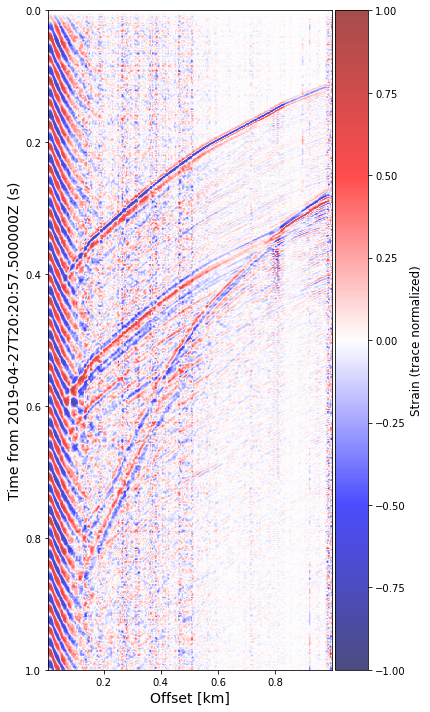

2001 976
(976, 2001)
(976, 2001)


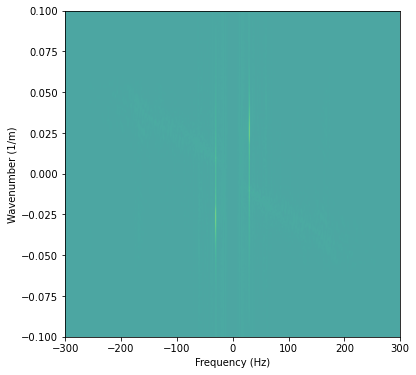

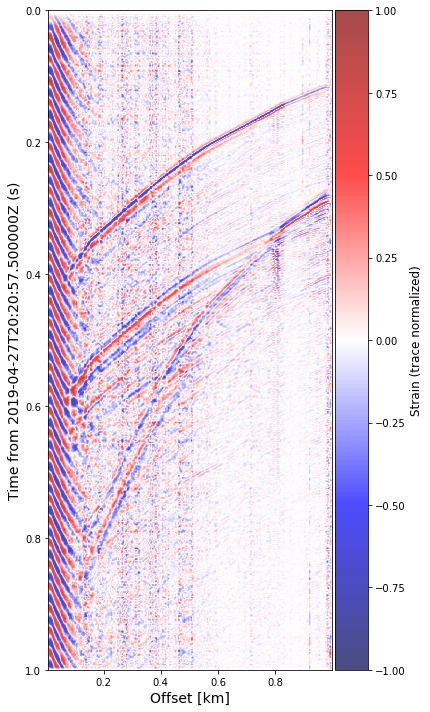

2001 976
(976, 2001)
(976, 2001)


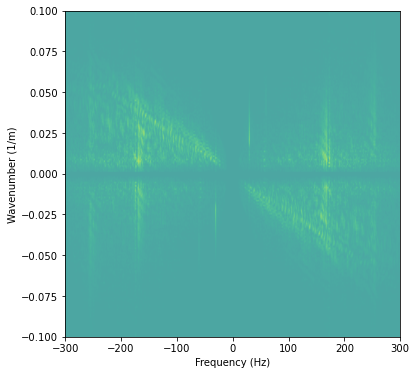

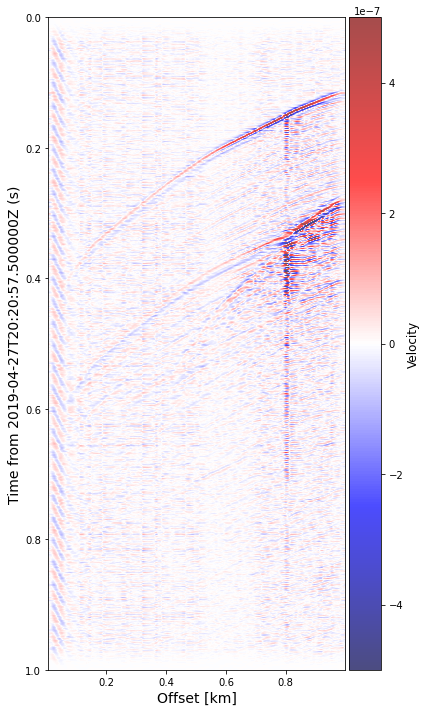

In [11]:
fig=plt.figure(figsize=[6,10])
fig=image(st_strain,style=2,skip=1,tmax=1,clim=[-1,1], physicalFiberLocations=True,fig=fig)
plt.ylabel('Time from %s (s)'%(das_start),fontsize=14)
plt.show()

st_tmp=st_strain.copy()
st_strain_fk=fk_filter(st_tmp, wavenumber_limits=(-2, 2), freq_limits=(-400, 400), taper=0.01,resample=False,eta=1e-2)

fig=plt.figure(figsize=[6,10])
fig=image(st_strain_fk,style=2,skip=1,tmax=1,clim=[-1,1], physicalFiberLocations=True,fig=fig)
plt.ylabel('Time from %s (s)'%(das_start),fontsize=14)
plt.show()

st_tmp=st_strain.copy()
st_vel=fk_filter(st_tmp, wavenumber_limits=(-2, 2), freq_limits=(-400, 400), taper=0.1,resample=True,eta=1e-2)

fig=plt.figure(figsize=[6,10])
fig=image(st_vel,style=1,skip=1,tmax=1,clim=[-5e-7,5e-7], physicalFiberLocations=True,fig=fig)
plt.ylabel('Time from %s (s)'%(das_start),fontsize=14)
plt.show()


Event depth 767.2


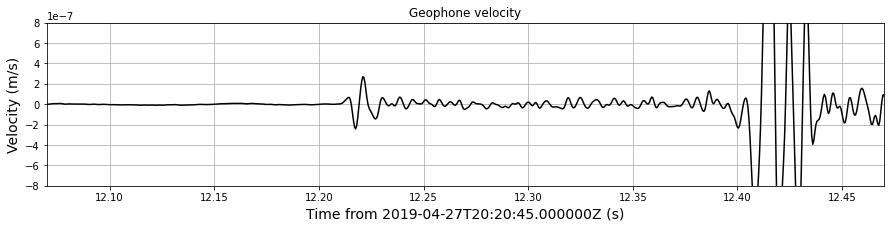

DAS at channel at 766.96


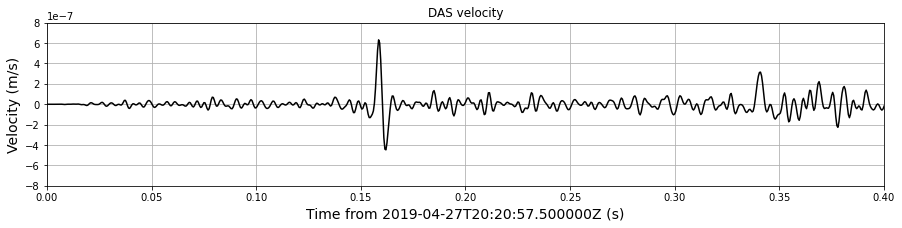

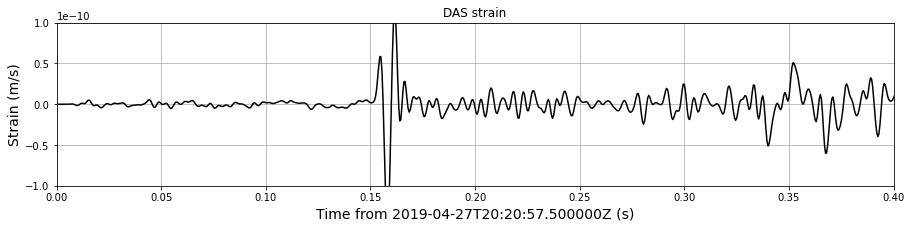

In [12]:
trace=13

print('Event depth %s' %(st_ps1_geo[trace].stats.segy['trace_header']['receiver_group_elevation']/100))
geo_start=st_ps1_geo[trace].stats.starttime

plt.figure(figsize=[15,3])
plt.title("Geophone velocity")
plt.plot(st_ps1_geo[trace].times(),st_ps1_geo[trace].data,'k')
plt.xlim(12,14)
plt.xlabel('Time from %s (s)'%(geo_start),fontsize=14)
# plt.ylabel('Displacement (m)',fontsize=14)
plt.ylabel('Velocity (m/s)',fontsize=14)
plt.ylim(-8e-7,8e-7)
plt.xlim(12.07,12.47)
plt.grid()
plt.show()


i=747
print('DAS at channel at %s'%(st_vel[i].stats.distance))
das_start=st_vel[i].stats.starttime

# DAS velocitry plot
plt.figure(figsize=[15,3])
plt.title("DAS velocity")
plt.plot(st_vel[i].times(),st_vel[i].data,'k')
plt.xlabel('Time from %s (s)'%(das_start),fontsize=14)
plt.ylabel('Velocity (m/s)',fontsize=14)
plt.ylim(-8e-7,8e-7)
plt.xlim(0,0.4)
plt.grid()
plt.show()

# Strain plotted for comparison
plt.figure(figsize=[15,3])
plt.title("DAS strain")
plt.plot(st_strain[i].times(),st_strain[i].data,'k')
plt.xlabel('Time from %s (s)'%(das_start),fontsize=14)
# plt.ylabel('Displacement (m)',fontsize=14)
plt.ylabel('Strain (m/s)',fontsize=14)
plt.ylim(-1e-10,1e-10)
plt.xlim(0,0.4)
plt.grid()
plt.show()


